# XAI Pipeline for Skin Cancer Classification
This notebook loads the trained Xception model, applies there XAI methods (Grad-CAM, SHAP, Influence Functions), and exports the results in a format ready for the LLM integration pipeline.

## Import Libraries

In [1]:
# --- 1. Setup and Initialization ---
import sys
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

from torch.utils.data import DataLoader, TensorDataset
from torch import nn
from torch.nn import functional as F
from captum.attr import LayerGradCam, Occlusion
from captum.attr import visualization as viz

# Add project root to path
project_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if project_root not in sys.path:
    sys.path.append(project_root)
    print(f"Project root added to path: {project_root}")

# Import the new helper functions
from scd.utils.common import load_model, load_datasets, get_test_transforms
print("Libraries imported successfully.")

/Users/berkay/Projects/thesis-project/thesis-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Project root added to path: /Users/berkay/Projects/thesis-project


/Users/berkay/Projects/thesis-project/thesis-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Libraries imported successfully.


## Define Project Structure and File Paths

In [2]:
# --- 2. Define Project Structure and File Paths ---
BASE_DIR = project_root
MODEL_PATH = os.path.join(BASE_DIR, 'models', 'ResNet_skin_cancer_classification.pth')
PROCESSED_DATA_DIR = os.path.join(BASE_DIR, 'data', 'processed')
SAMPLE_IMAGE_PATH = os.path.join(BASE_DIR, 'user_inputs', 'user_sample1.jpg') # Assuming a sample image exists here
OUTPUT_DIR = os.path.join(BASE_DIR, 'results', 'xai_output')
os.makedirs(OUTPUT_DIR, exist_ok=True)

# New constant for image size
IMAGE_RESIZE = (384, 384)

print(f"Project Base Directory: {BASE_DIR}")
print(f"Using Model Path: {MODEL_PATH}")

Project Base Directory: /Users/berkay/Projects/thesis-project
Using Model Path: /Users/berkay/Projects/thesis-project/models/ResNet_skin_cancer_classification.pth


## Model Definition and Loading

In [3]:
# --- 3. Model Definition and Loading ---
print("\nLoading model...")
# Use the load_model helper function
model = load_model(MODEL_PATH)
model.eval()
print(f"Successfully loaded trained ResNet model.")


Loading model...
Successfully loaded trained ResNet model.


## Data Loading and Preprocessing

In [4]:
# --- 4. Data Loading and Preprocessing ---
print("\nLoading and preprocessing sample image...")
# Use the get_test_transforms helper function
preprocess_transform = get_test_transforms(resize=IMAGE_RESIZE)

try:
    input_image = Image.open(SAMPLE_IMAGE_PATH).convert('RGB')
    image_np = np.array(input_image)
    input_tensor = preprocess_transform(image=image_np)['image'].unsqueeze(0)
    print(f"Successfully loaded and preprocessed sample image: {SAMPLE_IMAGE_PATH}")
except FileNotFoundError:
    print(f"ERROR: Sample image not found at '{SAMPLE_IMAGE_PATH}'")


Loading and preprocessing sample image...
Successfully loaded and preprocessed sample image: /Users/berkay/Projects/thesis-project/user_inputs/user_sample1.jpg


## XAI Pipeline Implementation

In [5]:
# --- 5. XAI Pipeline Implementation ---
print("\n--- Running XAI Pipeline ---")

# Get model prediction
outputs, _ = model(input_tensor)
prediction_score, pred_label_idx = torch.topk(outputs, 1)
predicted_class_index = pred_label_idx.squeeze().item()
class_names = ['Benign', 'Malignant']
print(f"Model Prediction: Class '{class_names[predicted_class_index]}' with confidence {prediction_score.item():.2%}")

# Create and save the model output DataFrame
benign_prob = outputs[0][0].item()
malignant_prob = outputs[0][1].item()

# Create a list of dictionaries for the two rows
output_data = [
    {'class': 'Benign', 'confidence': benign_prob},
    {'class': 'Malignant', 'confidence': malignant_prob}
]
output_df = pd.DataFrame(output_data)

# Save the file
model_output_path = os.path.join(OUTPUT_DIR, 'model_output.csv')
output_df.to_csv(model_output_path, index=False)
print(f"Model output saved to: {model_output_path}")

# Wrapper function for Captum
def model_forward_wrapper(input_tensor):
    """Wrapper to return only the logits tensor from the model's output."""
    return model(input_tensor)[0] # Return only the first element (the predictions)


--- Running XAI Pipeline ---
Model Prediction: Class 'Benign' with confidence 92.01%
Model output saved to: /Users/berkay/Projects/thesis-project/results/xai_output/model_output.csv


[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


### Grad-CAM Implementation


--- Generating Grad-CAM ---


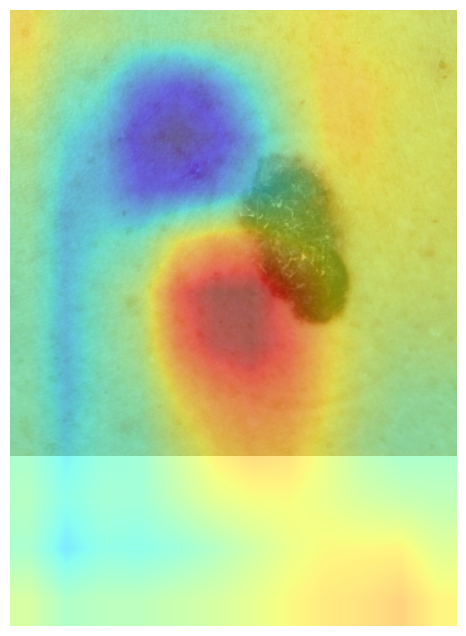

Grad-CAM image saved to: /Users/berkay/Projects/thesis-project/results/xai_output/user_sample1_xai_gradcam.png


In [6]:
# --- 5a. Grad-CAM Implementation ---
print("\n--- Generating Grad-CAM ---")
# Target layer for ResNet model from scd/model.py
grad_cam_layer = model.features[-1] 
layer_gc = LayerGradCam(model_forward_wrapper, grad_cam_layer) # Use the wrapper
attribution_gc = layer_gc.attribute(input_tensor, target=predicted_class_index)

heatmap = F.interpolate(attribution_gc, size=input_image.size, mode='bilinear', align_corners=False)
heatmap = heatmap.squeeze().cpu().detach().numpy()

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(input_image)
ax.imshow(heatmap, cmap='jet', alpha=0.5)
ax.axis('off')
grad_cam_output_path = os.path.join(OUTPUT_DIR, 'user_sample1_xai_gradcam.png')
plt.savefig(grad_cam_output_path, bbox_inches='tight', pad_inches=0)
plt.show()
print(f"Grad-CAM image saved to: {grad_cam_output_path}")

### SHAP


--- Generating SHAP ---


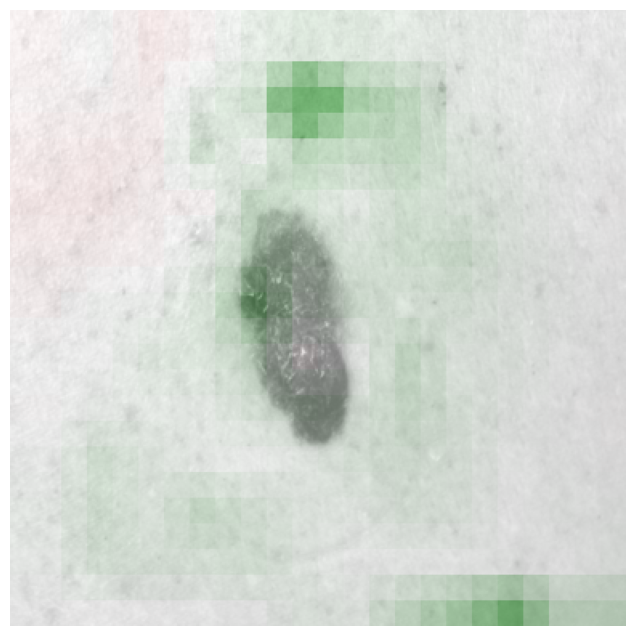

SHAP image saved to: /Users/berkay/Projects/thesis-project/results/xai_output/user_sample1_xai_shap.png


In [7]:
# --- 5b. SHAP (using Occlusion) ---
print("\n--- Generating SHAP ---")
occlusion = Occlusion(model_forward_wrapper) # Use the wrapper here
# Adjust sliding window shapes for the new 384x384 size
attribution_shap = occlusion.attribute(input_tensor, 
                                       strides=(3, 32, 32), 
                                       target=predicted_class_index, 
                                       sliding_window_shapes=(3, 48, 48),
                                       baselines=0)

fig_shap, ax_shap = plt.subplots(figsize=(8, 8))
ax_shap.axis('off')
viz.visualize_image_attr(np.transpose(attribution_shap.squeeze().cpu().detach().numpy(), (1,2,0)), 
                         np.array(input_image.resize(IMAGE_RESIZE)), 
                         method="blended_heat_map", 
                         sign="all", 
                         show_colorbar=False, 
                         plt_fig_axis=(fig_shap, ax_shap))
shap_output_path = os.path.join(OUTPUT_DIR, 'user_sample1_xai_shap.png')
fig_shap.savefig(shap_output_path, bbox_inches='tight', pad_inches=0)
plt.show()
print(f"SHAP image saved to: {shap_output_path}")

### Influence Functions

In [8]:
# --- 5c. Influence Functions ---
print("\n--- Generating Influence Functions ---")
def get_gradient_and_prediction(model, data_tensor, target, loss_fn):
    model.zero_grad()
    # Use the wrapper to get logits
    logits = model_forward_wrapper(data_tensor)
    _, pred_idx = torch.max(logits.data, 1)
    loss = loss_fn(logits, target)
    loss.backward()
    # Get gradient from the final classifier layer of the ResNet model
    grad = model.classifier[-1].weight.grad.detach().clone()
    return grad.flatten(), pred_idx.item()

def calculate_real_influence(model, train_loader, test_tensor, test_target, device):
    model.to(device)
    model.eval()
    test_tensor = test_tensor.to(device)
    test_target = torch.tensor([test_target]).to(device)
    loss_fn = nn.CrossEntropyLoss()
    
    print("Calculating gradient for the test image...")
    test_grad, _ = get_gradient_and_prediction(model, test_tensor, test_target, loss_fn)
    
    results = []
    print("Iterating through the training dataset to calculate influence scores...")
    for (train_imgs, train_labels, filenames) in tqdm(train_loader):
        train_imgs, train_labels = train_imgs.to(device), train_labels.to(device)
        for i in range(len(train_imgs)):
            train_grad, train_pred = get_gradient_and_prediction(model, train_imgs[i].unsqueeze(0), train_labels[i].unsqueeze(0), loss_fn)
            influence_score = torch.dot(test_grad, train_grad).item()
            results.append({'score': influence_score, 'prediction': train_pred, 'filename': filenames[i]})
    return results

try:
    print(f"Loading processed training data from: {PROCESSED_DATA_DIR}")
    # Load data using the new helper function
    train_dataset, train_filenames = load_datasets(PROCESSED_DATA_DIR, only_train_dataset_with_filenames=True)
    
    # Create a new TensorDataset that includes filenames for the loader
    class DatasetWithFilenames(TensorDataset):
        def __init__(self, tensors, filenames):
            super(DatasetWithFilenames, self).__init__(*tensors)
            self.filenames = filenames
        def __getitem__(self, index):
            return super(DatasetWithFilenames, self).__getitem__(index) + (self.filenames[index],)

    train_images_tensors, train_labels_tensors = train_dataset.tensors
    train_dataset_with_files = DatasetWithFilenames((train_images_tensors, train_labels_tensors), train_filenames)
    train_loader = DataLoader(train_dataset_with_files, batch_size=32)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    influence_results = calculate_real_influence(model, train_loader, input_tensor, predicted_class_index, device)
    
    # The ground truth is now part of the dataset, not a separate CSV
    gt_map = {fname: label.item() for fname, label in zip(train_filenames, train_labels_tensors)}

    report_data = [{'case_id': r['filename'].split('.')[0], 
                    'influence_score': r['score'], 
                    'ground_truth': gt_map.get(r['filename'], -1), # Look up ground truth
                    'prediction': r['prediction']} for r in influence_results]
    
    report_df = pd.DataFrame(report_data)
    report_df['abs_influence'] = report_df['influence_score'].abs()
    report_df = report_df.sort_values(by='abs_influence', ascending=False).drop(columns='abs_influence')
    final_report_df = report_df.head(100)

    influence_output_path = os.path.join(OUTPUT_DIR, 'user_sample1_influence_function.csv')
    final_report_df.to_csv(influence_output_path, index=False)
    print(f"\nSuccessfully saved {len(final_report_df)} influence scores to: {influence_output_path}")

except FileNotFoundError as e:
    print(f"ERROR: A required data file was not found. Please ensure notebooks 01 and 02 have been run. Details: {e}")

print("\n\n--- XAI Pipeline Execution Complete ---")


--- Generating Influence Functions ---
Loading processed training data from: /Users/berkay/Projects/thesis-project/data/processed
Calculating gradient for the test image...
Iterating through the training dataset to calculate influence scores...


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [17:21<00:00, 20.82s/it]


Successfully saved 100 influence scores to: /Users/berkay/Projects/thesis-project/results/xai_output/user_sample1_influence_function.csv


--- XAI Pipeline Execution Complete ---
